In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
# Import custom data generation models from the mfpi folder
import sys
sys.path.append("../")
from mfpi import data_gen_models as data

## Data generating model

We generate data from a toy model with one explanatory variable and one response variable.

In [3]:
# Set a random seed for reproducibility
np.random.seed(2023)

In [4]:
# Non-linear model with heteroschedastic errors
data_model = data.Model_Reg5(x_shift=0, a=1.5)

# Non-linear model with heteroschedastic errors and shift
data_model_shift = data.Model_Reg5(x_shift=0.2, a=1.5)

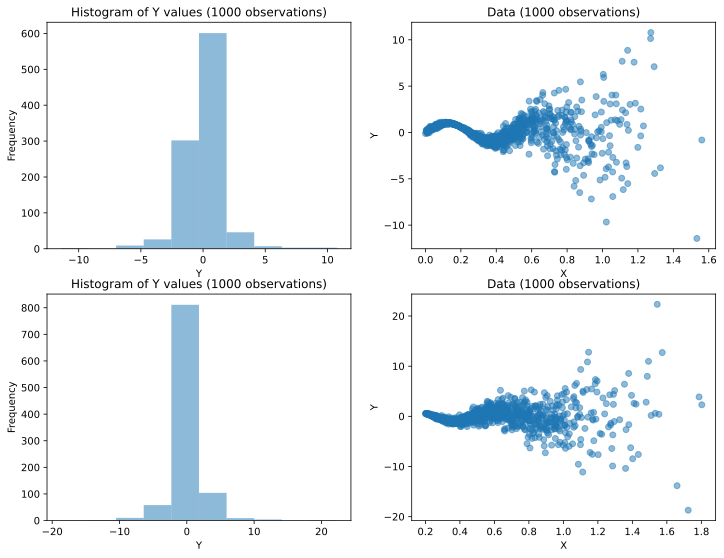

In [5]:
# Generate the labeled data
n_data = 1000
X_data, Y_data = data_model.sample(n_data)

# Generate the test data
n_test = 1000
X_test, Y_test = data_model_shift.sample(n_test)

# Prepare to make side-to-side plots
plt.figure(figsize=(12,9))

# Plot histogram of Y values
plt.subplot(2, 2, 1)
plt.hist(Y_data, alpha=0.5)
plt.xlabel("Y")
plt.ylabel("Frequency")
plt.title("Histogram of Y values ({:d} observations)".format(n_data))

# Make scatter plot of the data
plt.subplot(2, 2, 2)
plt.scatter(X_data[:,0], Y_data, alpha=0.5)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Data ({:d} observations)".format(n_data))

# Plot histogram of Y values
plt.subplot(2, 2, 3)
plt.hist(Y_test, alpha=0.5)
plt.xlabel("Y")
plt.ylabel("Frequency")
plt.title("Histogram of Y values ({:d} observations)".format(n_data))

# Make scatter plot of the data
plt.subplot(2, 2, 4)
plt.scatter(X_test[:,0], Y_test, alpha=0.5)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Data ({:d} observations)".format(n_data))
plt.show()

## Useful functions

In [6]:
def eval_predictions(X_test, Y_test, lower, upper, show_plot=True):
    covered = (Y_test>=lower) * (Y_test <= upper)
    coverage = np.mean(covered)
    width = np.mean(upper-lower)
        
    # Plot the prediction bands and compare them to the test data
    if show_plot:
        order = np.argsort(X_test[:,0])
        plt.scatter(X_test[order,0], Y_test[order], alpha=0.5)
        plt.plot(X_test[order,0], lower[order], color="red")
        plt.plot(X_test[order,0], upper[order], color="red")
        plt.xlabel("X")
        plt.ylabel("Y")
        txt_subtitle = "Coverage: {:.3f}, Average width: {:.3f}".format(coverage, width)
        plt.title("Test data and prediction bands (alpha: {:.2f})\n".format(alpha)+txt_subtitle)
        plt.show()
    
    return coverage, width

## Prediction with a machine learning model

We now fit a more sophisticated machine learning model on the training data.

To learn more about the Python sklearn package: https://scikit-learn.org/stable/index.html

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

# Choose a black-box machine learning model (1,2,3,4)
bb_model_index = 1

if bb_model_index==1:
    # Random forest
    black_box = RandomForestRegressor(n_estimators=100, min_samples_split=10, random_state=2023)
elif bb_model_index==2:
    # Random forest with more aggressive splits
    black_box = RandomForestRegressor(n_estimators=100, min_samples_split=1, random_state=2023)
elif bb_model_index==3:
    # Support vector machine
    black_box = SVR(kernel='rbf', degree=3)
elif bb_model_index==4:
    # Neural network
    black_box = MLPRegressor(hidden_layer_sizes=(200,), max_iter=1000, random_state=2023)
else:
    print("Error: unknown machine learning model")
    black_box = None

In [8]:
from scipy.stats.mstats import mquantiles

def naive_prediction_intervals(X, Y, X_test, black_box, alpha):
    """
    Compute naive prediction bands based on the distribution of
      residuals within the training data set
      
    Input
    X         : n x p data matrix of explanatory variables
    Y         : n x 1 vector of response variables
    X_test    : n x p test data matrix of explanatory variables
    black_box : sklearn model object with 'fit' and 'predict' methods
    alpha     : 1 - target coverage level 
    """
    
    # Output placeholder
    lower = None
    upper = None
    
    # Fit the black box model on the training data
    black_box.fit(X, Y)
    
    # Compute residuals on the training data
    residuals_calib = np.abs(Y - black_box.predict(X))
    
    # Compute suitable empirical quantile of absolute residuals
    n_calib = len(Y)
    level_adjusted = 1.0-alpha
    Q_hat = mquantiles(residuals_calib, prob=level_adjusted)[0]
    
    # Construct prediction bands
    Y_hat = black_box.predict(X_test)
    lower = Y_hat - Q_hat
    upper = Y_hat + Q_hat
    
    return lower, upper 

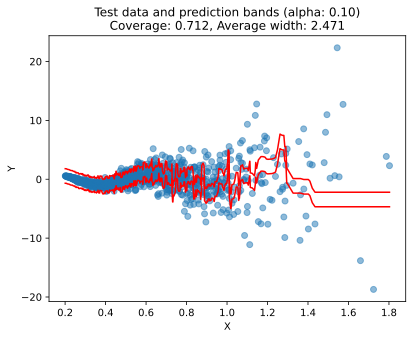

In [9]:
# Desired coverage level (1-alpha)
alpha = 0.1

# Apply split conformal
lower_naive, upper_naive = naive_prediction_intervals(X_data, Y_data, X_test, black_box, alpha)

# Evaluate the predictions
_, _ = eval_predictions(X_test, Y_test, lower_naive, upper_naive)

## Conformal prediction

Let's construct conformal prediction intervals.

Hint: read about the function `train_test_split`: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [10]:
from sklearn.model_selection import train_test_split

def conformal_prediction_intervals(X, Y, X_test, black_box, alpha, random_state=2023):
    """
    Compute conformal prediction bands
    
    Input
    X         : n x p data matrix of explanatory variables
    Y         : n x 1 vector of response variables
    X_test    : n x p test data matrix of explanatory variables
    black_box : sklearn model object with 'fit' and 'predict' methods
    alpha     : 1 - target coverage level 
    """
    
    # Output placeholder
    lower = None
    upper = None
    
    # Split the data into training and calibration sets
    X_train, X_calib, Y_train, Y_calib = train_test_split(X, Y, test_size=0.5, random_state=random_state)
    
    # Fit the black box model on the training data
    """TODO: write your code here (1 line)"""
    
    # Compute residuals on the calibration data
    """TODO: write your code here (1 line)"""
    
    # Compute suitable empirical quantile of absolute residuals
    """TODO: write your code here (3 lines)"""
    
    # Construct prediction bands
    """TODO: write your code here (3 lines)"""
    
    return lower, upper  

In [11]:
from sklearn.model_selection import train_test_split

def conformal_prediction_intervals(X, Y, X_test, black_box, alpha, random_state=2023):
    """
    Compute conformal prediction bands
    
    Input
    X         : n x p data matrix of explanatory variables
    Y         : n x 1 vector of response variables
    X_test    : n x p test data matrix of explanatory variables
    black_box : sklearn model object with 'fit' and 'predict' methods
    alpha     : 1 - target coverage level 
    """
    
    # Output placeholder
    lower = None
    upper = None
    
    # Split the data into training and calibration sets
    X_train, X_calib, Y_train, Y_calib = train_test_split(X, Y, test_size=0.5, random_state=random_state)
    
    # Fit the black box model on the training data
    black_box.fit(X_train, Y_train)
    
    # Compute residuals on the calibration data
    residuals_calib = np.abs(Y_calib - black_box.predict(X_calib))
    
    # Compute suitable empirical quantile of absolute residuals
    n_calib = len(Y_calib)
    level_adjusted = (1.0-alpha)*(1.0+1.0/float(n_calib))
    Q_hat = mquantiles(residuals_calib, prob=level_adjusted)[0]
    
    # Construct prediction bands
    Y_hat = black_box.predict(X_test)
    lower = Y_hat - Q_hat
    upper = Y_hat + Q_hat
    
    return lower, upper 

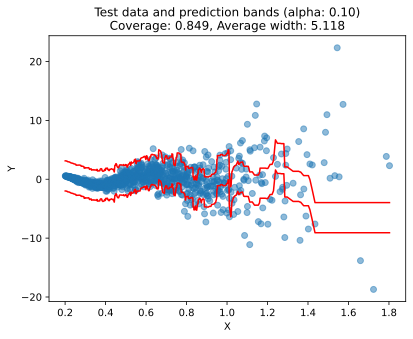

In [12]:
# Desired coverage level (1-alpha)
alpha = 0.1

# Apply split conformal
lower, upper = conformal_prediction_intervals(X_data, Y_data, X_test, black_box, alpha)

# Evaluate the predictions
_, _ = eval_predictions(X_test, Y_test, lower, upper)

## Oracle predictions

Since we know the data generating model, we have access to oracle prediction intervals.

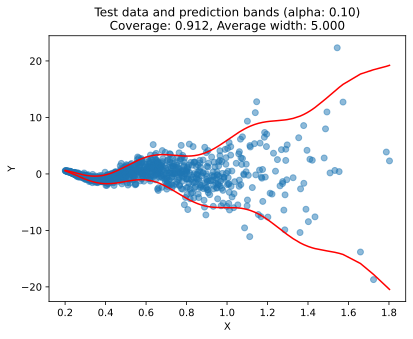

In [13]:
lower_oracle, upper_oracle = data_model.oracle_predict(X_test, alpha)

# Evaluate the predictions
_, _ = eval_predictions(X_test, Y_test, lower_oracle, upper_oracle)

## Quantile regression

Let's now play fair and forget about the oracle.
We will use a black-box quantile regression model instead.

In [14]:
# Import custom quantile regression models from the mfpi folder
import sys
sys.path.append("../")
from mfpi import qr_models as qr

In [63]:
# Choose a black-box quantile regression model (1 or 2)
bb_qr_model_index = 2

alpha = 0.1

if bb_qr_model_index==1:
    # Random forest
    black_box_qr = qr.LinearQR(alpha=0.1)
elif bb_qr_model_index==2:
    black_box_qr = qr.RFQR(n_estimators=20)
else:
    print("Error: unknown quantile regression model")
    black_box_qr = None

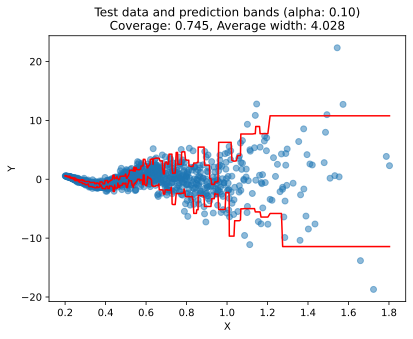

In [64]:
# Fit the quantile regression model
black_box_qr.fit(X_data, Y_data)

# Estimate conditional quantiles for data set
lower_qr, upper_qr = black_box_qr.predict(X_test)

# Evaluate the predictions
_, _ = eval_predictions(X_test, Y_test, lower_qr, upper_qr)

## Conformalized quantile regression

Since we don't want to blindly trust the black-box quantile regression model, we will use conformal inference to correct the prediction intervals.

To learn more about quantile regression with random forests in Python: https://pypi.org/project/quantile-forest/

In [65]:
from sklearn.model_selection import train_test_split

def cqr_prediction_intervals(X, Y, X_test, black_box, alpha, random_state=2023):
    """
    Compute split-conformal quantile regression prediction bands.
    Uses quantile random forests as a black box 
    
    Input
    X         : n x p data matrix of explanatory variables
    Y         : n x 1 vector of response variables
    X_test    : n x p test data matrix of explanatory variables
    black_box : quantile regression model object with 'fit' and 'predict' methods
    alpha     : 1 - target coverage level 
    """
    
    # Output placeholder
    lower = None
    upper = None
    
    # Split the data into training and calibration sets
    """TODO: write your code here (1 line)"""
    
    # Fit the quantile regression model
    """TODO: write your code here (1 line)"""

    # Estimate conditional quantiles for calibration set
    """TODO: write your code here (2 lines)"""
    
    # Compute conformity scores on the calibration data
    """TODO: write your code here (1 line)"""
    
    # Compute suitable empirical quantile of absolute residuals
    """TODO: write your code here (3 lines)"""
    
    # Construct prediction bands
    """TODO: write your code here (3 lines)"""
    
    return lower, upper 

In [66]:
from sklearn.model_selection import train_test_split

def cqr_prediction_intervals(X, Y, X_test, black_box, alpha, random_state=2023):
    """
    Compute split-conformal quantile regression prediction bands.
    Uses quantile random forests as a black box 
    
    Input
    X         : n x p data matrix of explanatory variables
    Y         : n x 1 vector of response variables
    X_test    : n x p test data matrix of explanatory variables
    black_box : quantile regression model object with 'fit' and 'predict' methods
    alpha     : 1 - target coverage level 
    """
    
    # Output placeholder
    lower = None
    upper = None
    
    # Split the data into training and calibration sets
    """TODO: write your code here (1 line)"""
    X_train, X_calib, Y_train, Y_calib = train_test_split(X, Y, test_size=0.5, random_state=random_state)
    
    # Fit the quantile regression model
    """TODO: write your code here (1 line)"""
    black_box.fit(X_train, Y_train)

    # Estimate conditional quantiles for calibration set
    """TODO: write your code here (2 lines)"""
    lower, upper = black_box.predict(X_calib)
    
    # Compute conformity scores on the calibration data
    """TODO: write your code here (1 line)"""
    residuals_calib = np.maximum(Y_calib - upper, lower - Y_calib)
    
    # Compute suitable empirical quantile of absolute residuals
    """TODO: write your code here (3 lines)"""
    n_calib = len(Y_calib)
    level_adjusted = (1.0-alpha)*(1.0+1.0/float(n_calib))
    Q_hat = mquantiles(residuals_calib, prob=level_adjusted)[0]
    
    # Construct prediction bands
    """TODO: write your code here (3 lines)"""
    lower, upper = black_box.predict(X_test)
    lower = lower - Q_hat
    upper = upper + Q_hat
    
    return lower, upper 

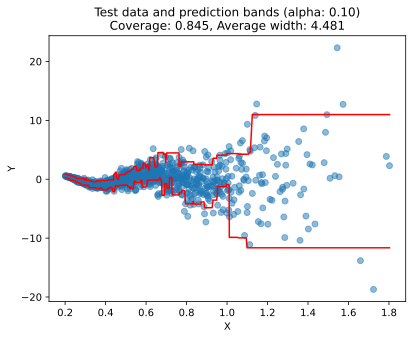

In [67]:
# Desired coverage level (1-alpha)
alpha = 0.1

# Apply quantile regression split conformal
lower_cqr, upper_cqr = cqr_prediction_intervals(X_data, Y_data, X_test, black_box_qr, alpha)

# Evaluate the predictions
_, _ = eval_predictions(X_test, Y_test, lower_cqr, upper_cqr)

## Repeated experiments

In [68]:
def evaluate_predictions(lower, upper, X, Y, verbose=True):
    """
    Evaluate performance metrics for a set of regression predictions
    Computes:
    - marginal coverage
    - average size of sets
    
    Input
    lower     : n x 1 vector of prediction lower bounds
    upper     : n x 1 vector of prediction upper upper
    X         : n x p data matrix of explanatory variables
    Y         : n x 1 vector of response variables
    """
    
    # Number of samples
    n = len(Y)
    
    # Evaluate the empirical coverage
    covered = (Y>=lower) * (Y <= upper)

    # Compute marginal coverage
    marginal_coverage = np.mean(covered)
    
    # Compute average size of prediction sets
    size = np.mean(upper-lower)
    
    # Compute average size of prediction sets that contain the true label
    idx_cover = np.where(covered)[0]
    size_cover = np.mean(upper[idx_cover]-lower[idx_cover])
    
    # Print summary
    if verbose:
        print('Marginal coverage       : {:2.3%}'.format(marginal_coverage))
        print('Average length          : {:2.3f}'.format(size))
        
    return marginal_coverage, size

In [69]:
def run_experiment(x_shift, black_box, black_box_qr, random_state=2023):
    np.random.seed(random_state)
    
    # Non-linear model with heteroschedastic errors
    data_model = data.Model_Reg5(x_shift=0, a=1.5)

    # Non-linear model with heteroschedastic errors and shift
    data_model_shift = data.Model_Reg5(x_shift=x_shift, a=1.5)

    # Generate the labeled data
    n_data = 1000
    X_data, Y_data = data_model.sample(n_data)

    # Generate the test data
    n_test = 1000
    X_test, Y_test = data_model_shift.sample(n_test)

    # Run and evaluate naive
    lower_naive, upper_naive = naive_prediction_intervals(X_data, Y_data, X_test, black_box, alpha)
    metrics_naive = evaluate_predictions(lower_naive, upper_naive, X_test, Y_test, verbose=False)
    
    # Run and evaluate conformal
    lower_conformal, upper_conformal = conformal_prediction_intervals(X_data, Y_data, X_test, black_box, alpha, random_state=random_state)
    metrics_conformal = evaluate_predictions(lower_conformal, upper_conformal, X_test, Y_test, verbose=False)
    
    # Run and evaluate CQR
    lower_cqr, upper_cqr = cqr_prediction_intervals(X_data, Y_data, X_test, black_box_qr, alpha, random_state=random_state)
    metrics_cqr = evaluate_predictions(lower_cqr, upper_cqr, X_test, Y_test, verbose=False)
       
    # Return results
    results_exp = pd.DataFrame({"Shift": [x_shift,x_shift,x_shift],
                                "Method":["Naive", "Conformal", "CQR"], 
                                "Coverage":[metrics_naive[0], metrics_conformal[0], metrics_cqr[0]],
                                "Length":[metrics_naive[1], metrics_conformal[1], metrics_cqr[1]],
                  })
    return results_exp

In [70]:
import pandas as pd

# List of covariate shift values
x_shift_list = [0,0.1,0.2,0.3,0.4,0.5]

# Run many experiments
results = pd.DataFrame()

from tqdm import tqdm

for experiment in tqdm(range(20)):
    
    for x_shift in x_shift_list:
        # Random state for this experiment
        random_state = 2023 + experiment

        # Run the experiment
        result_exp = run_experiment(x_shift, black_box, black_box_qr, random_state=random_state)

        # Store results
        results = pd.concat([results,result_exp])

100%|███████████████████████████████████████████| 20/20 [00:35<00:00,  1.76s/it]


In [71]:
summary = results.groupby(['Shift','Method']).agg('mean').reset_index()

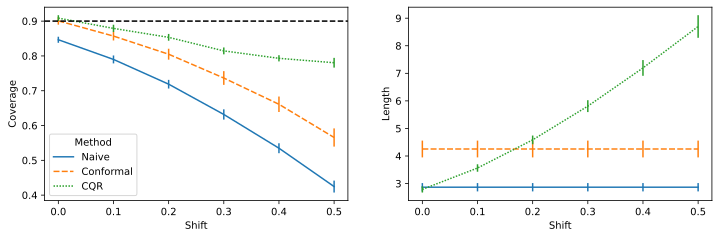

In [72]:
import seaborn as sns

plt.figure(figsize=(12,3.5))

plt.subplot(1, 2, 1)

ax = sns.lineplot(data=results, x="Shift", y="Coverage",style="Method", hue="Method", err_style="bars", errorbar=("se", 2))
ax.axhline(1-alpha, ls='--', color="black")

plt.subplot(1, 2, 2)

sns.lineplot(data=results, x="Shift", y="Length",style="Method", hue="Method", err_style="bars", errorbar=("se", 2))
plt.legend([],[], frameon=False)
plt.show()